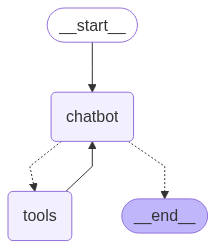

東京の代表的な建造物について5つほど教えてください。

[{"url": "https://www.japan-guide.com/e/e2164.html", "content": "Shibuya\n       Shinjuku\n       Meiji Shrine\n       Harajuku\n       Shinjuku Gyoen\n       Yoyogi Park\n       Government Building\n       Nakano Broadway\n       Kagurazaka\n       Yebisu Garden Place\n       Daikanyama\n\n   Southern Tokyo [...] Tokyo National Museum\n       Tokyo Skytree\n       Asakusa\n       Sensoji Temple\n       Edo-Tokyo Museum\n       Rikugien\n       Ueno Park\n       Tokyo Solamachi\n       Botanical Garden\n       Yanaka\n       Sumida Aquarium\n       Ameyoko\n       Ikebukuro\n       Sumida Hokusai Museum\n       Kappabashi Street\n       Ryogoku\n       Sugamo\n\n   Western Tokyo [...] Odaiba\n       Institute for Nature\n       Roppongi Hills\n       Toyosu Market\n       Tokyo Tower\n       Zojoji Temple\n       Sengakuji Temple\n       Tokyo Water Bus\n       Kyu Shiba Rikyu\n       Tokyo Midtown\n       Roppongi\n       Akasaka Sacas\n       Shiodome\n   

In [8]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ===== Stateクラスの定義 =====
class State(TypedDict):
    messages: Annotated[list, add_messages]

# ===== グラフの構築 =====
def build_graph(model_name):
    # ソースコードを記述
    # ツール定義
    tools = [TavilySearchResults(max_results=2)]

    # グラフのインスタンスを作成
    graph_builder = StateGraph(State)

    # チャットボットノードを作成し、グラフに追加
    llm = ChatOpenAI(model_name=model_name)
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: State):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}
    graph_builder.add_node("chatbot", chatbot)

    # ツールノードを作成し、グラフに追加
    tool_node = ToolNode(tools)
    graph_builder.add_node("tools", tool_node)

    # 条件付きエッジの作成
    graph_builder.add_conditional_edges(
        "chatbot",
        tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
    )

    # ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
    # ツールからチャットボットへの戻りエッジを作成
    graph_builder.add_edge("tools", "chatbot")

    # 開始ノードの指定
    graph_builder.set_entry_point("chatbot")

    # 記憶を持つ実行可能なステートグラフを作成し、返す
    memory = MemorySaver()
    return graph_builder.compile(checkpointer=memory)


# ===== グラフ実行関数 =====
def stream_graph_updates(graph: StateGraph, user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# ===== メイン実行ロジック =====
# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini" 

# グラフの作成
# ソースコードを記述
graph = build_graph(MODEL_NAME)

# グラフの可視化
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

# メインループ
# ソースコードを記述
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(graph, user_input)